In [1]:
import time

import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

In [2]:
(train_x, _), _ = keras.datasets.mnist.load_data()

In [3]:
print(f'Images shape: {train_x.shape}')

Images shape: (60000, 28, 28)


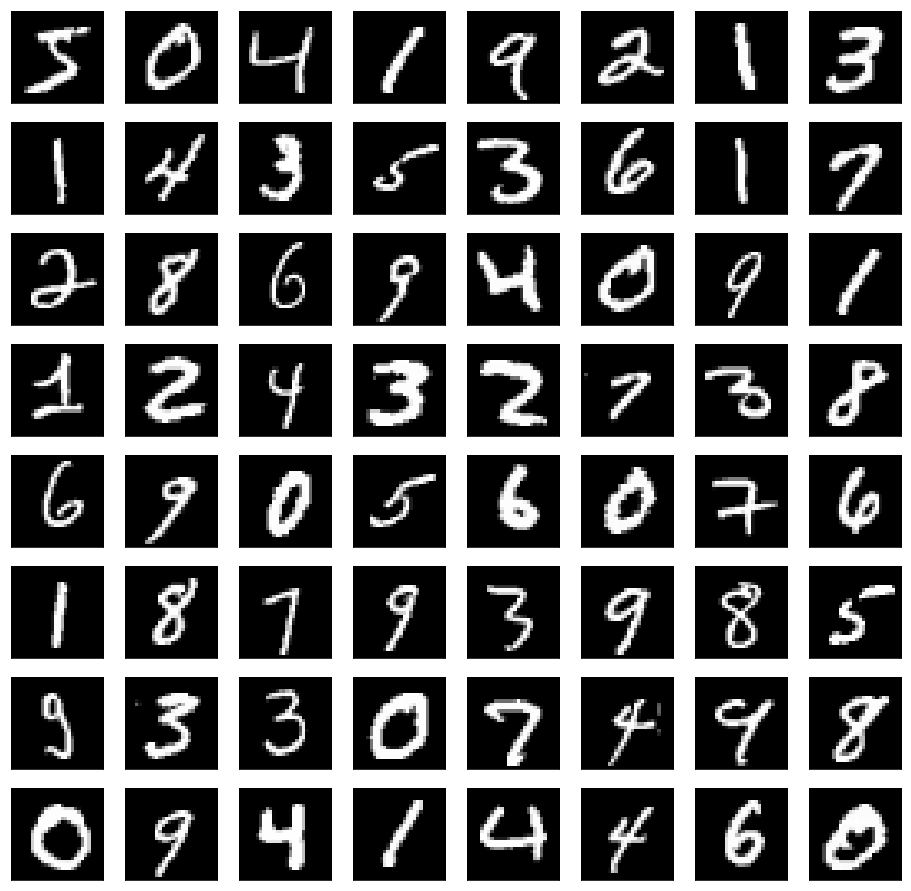

In [4]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
train_x = train_x.astype(np.float32) / 127.5 - 1

In [6]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('Visualization of loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('Visualization of accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [7]:
generator = keras.Sequential([
    keras.layers.Dense(250, input_shape=(100,)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(500),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(1000),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(784, activation='tanh'),
    keras.layers.Reshape((28, 28))])
generator.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               25250     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 250)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               125500    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              501000    
__________

In [8]:
discriminator = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(500),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(250),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')])
discriminator.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
__________

In [9]:
discriminator.trainable = False
inputs = keras.layers.Input(shape=(100,))
outputs = discriminator(generator(inputs))

combined = keras.Model(inputs=inputs, outputs=outputs)
combined.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28)            1443534   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 518001    
Total params: 1,961,535
Trainable params: 1,440,034
Non-trainable params: 521,501
_________________________________________________________________


In [10]:
def train(images, batch_size=32, epochs=1):
    history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
    batch_n = int(images.shape[0] / batch_size)

    for epoch in range(0, epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        start_time = time.time()

        d_loss, g_loss, d_acc = 0, 0, 0
        for _ in range(batch_n):
            real_images = images[np.random.randint(0, images.shape[0], batch_size)]
            generated_images = generator.predict(np.random.normal(0, 1, (batch_size, 100)))
            # Train discriminator
            x = np.vstack([real_images, generated_images])
            y = np.hstack([np.ones(batch_size), np.zeros(batch_size)])
            discriminator.trainable = True
            d_loss_batch, d_acc_batch = discriminator.train_on_batch(x, y)
            d_loss += d_loss_batch
            d_acc += d_acc_batch
            # Train generator
            x = np.random.normal(0, 1, size=(batch_size, 100))
            y = np.ones(batch_size)
            discriminator.trainable = False
            g_loss += combined.train_on_batch(x, y)

        d_loss /= batch_n
        d_acc /= batch_n
        g_loss /= batch_n
        history['epoch'].append(epoch)
        history['g_loss'].append(g_loss)
        history['d_loss'].append(d_loss)
        history['d_acc'].append(d_acc)

        dur = time.time() - start_time
        print(f' - {dur:.0f}s - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')
        
        if epoch == 0 or (epoch + 1) % 20 == 0 or epoch + 1 == epochs:
            generated_images = generator.predict(
                np.random.normal(0, 1, size=(24, 100)))
            plt.figure(figsize=(16, 6))
            for i in range(24):
                plt.subplot(3, 8, i + 1)
                plt.imshow(generated_images[i], cmap=plt.cm.gray)
                plt.xticks([])
                plt.yticks([])
            plt.show()
            
    return history

Epoch 1/400
 - 21s - g_loss: 12.2380 - d_loss: 0.0527 - d_acc: 0.9815


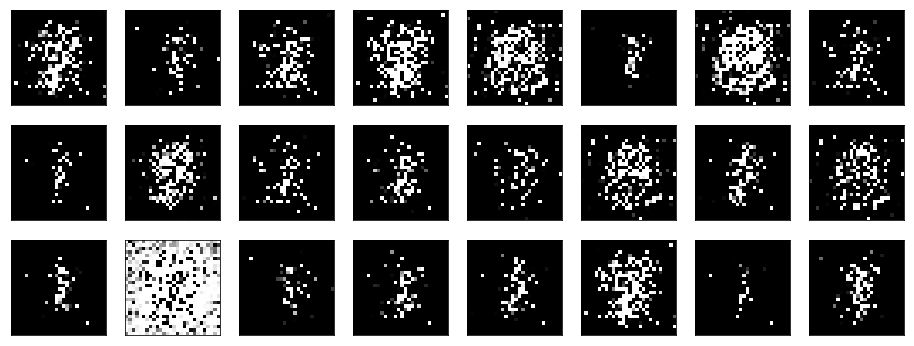

Epoch 2/400
 - 17s - g_loss: 9.9497 - d_loss: 0.0661 - d_acc: 0.9765
Epoch 3/400
 - 23s - g_loss: 8.6317 - d_loss: 0.0878 - d_acc: 0.9676
Epoch 4/400
 - 22s - g_loss: 7.2558 - d_loss: 0.1165 - d_acc: 0.9561
Epoch 5/400
 - 21s - g_loss: 7.0823 - d_loss: 0.1210 - d_acc: 0.9542
Epoch 6/400
 - 18s - g_loss: 6.2917 - d_loss: 0.1678 - d_acc: 0.9341
Epoch 7/400
 - 19s - g_loss: 5.2550 - d_loss: 0.2307 - d_acc: 0.9060
Epoch 8/400
 - 16s - g_loss: 4.6095 - d_loss: 0.2849 - d_acc: 0.8797
Epoch 9/400
 - 18s - g_loss: 4.5406 - d_loss: 0.3029 - d_acc: 0.8714
Epoch 10/400
 - 24s - g_loss: 3.8754 - d_loss: 0.3683 - d_acc: 0.8379
Epoch 11/400
 - 22s - g_loss: 3.5863 - d_loss: 0.4048 - d_acc: 0.8193
Epoch 12/400
 - 18s - g_loss: 3.6122 - d_loss: 0.4096 - d_acc: 0.8158
Epoch 13/400
 - 23s - g_loss: 3.3958 - d_loss: 0.4305 - d_acc: 0.8057
Epoch 14/400
 - 18s - g_loss: 3.1270 - d_loss: 0.4764 - d_acc: 0.7795
Epoch 15/400
 - 22s - g_loss: 3.3936 - d_loss: 0.4425 - d_acc: 0.7985
Epoch 16/400
 - 25s - g_loss

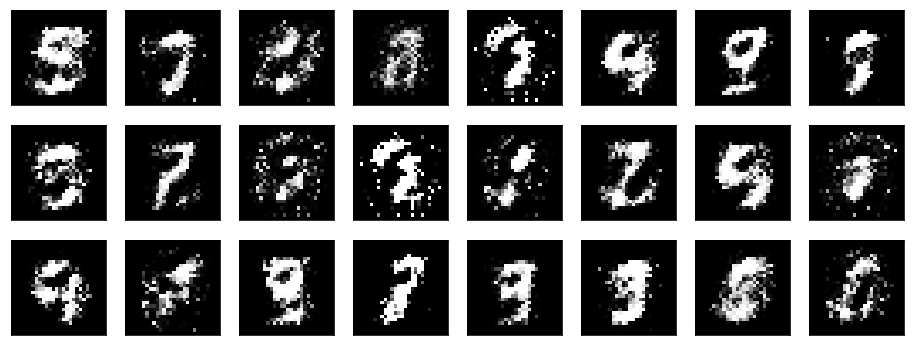

Epoch 21/400
 - 18s - g_loss: 2.5258 - d_loss: 0.5311 - d_acc: 0.7460
Epoch 22/400
 - 24s - g_loss: 2.4974 - d_loss: 0.5354 - d_acc: 0.7451
Epoch 23/400
 - 18s - g_loss: 2.2334 - d_loss: 0.5544 - d_acc: 0.7304
Epoch 24/400
 - 20s - g_loss: 2.4444 - d_loss: 0.5441 - d_acc: 0.7392
Epoch 25/400
 - 20s - g_loss: 2.2487 - d_loss: 0.5563 - d_acc: 0.7285
Epoch 26/400
 - 21s - g_loss: 2.4885 - d_loss: 0.5367 - d_acc: 0.7438
Epoch 27/400
 - 25s - g_loss: 2.2124 - d_loss: 0.5616 - d_acc: 0.7281
Epoch 28/400
 - 23s - g_loss: 2.0284 - d_loss: 0.5889 - d_acc: 0.7083
Epoch 29/400
 - 20s - g_loss: 2.2149 - d_loss: 0.5707 - d_acc: 0.7201
Epoch 30/400
 - 19s - g_loss: 2.1853 - d_loss: 0.5738 - d_acc: 0.7202
Epoch 31/400
 - 22s - g_loss: 1.9342 - d_loss: 0.5975 - d_acc: 0.7004
Epoch 32/400
 - 23s - g_loss: 2.0915 - d_loss: 0.5967 - d_acc: 0.7064
Epoch 33/400
 - 17s - g_loss: 2.1161 - d_loss: 0.5837 - d_acc: 0.7131
Epoch 34/400
 - 19s - g_loss: 1.9151 - d_loss: 0.6015 - d_acc: 0.6979
Epoch 35/400
 - 16s 

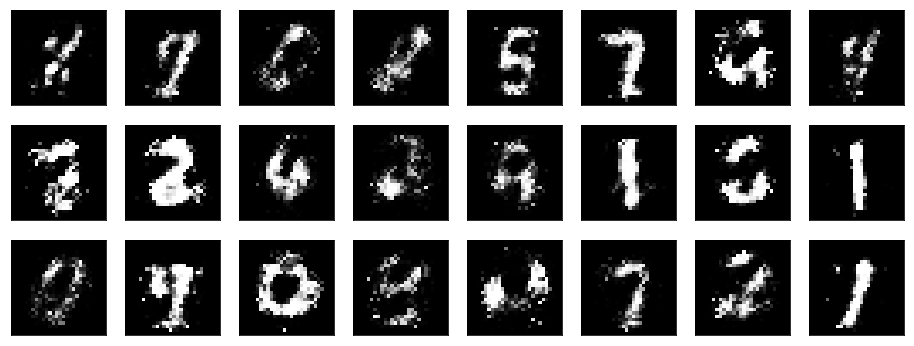

Epoch 41/400
 - 18s - g_loss: 1.8329 - d_loss: 0.6273 - d_acc: 0.6817
Epoch 42/400
 - 20s - g_loss: 1.9674 - d_loss: 0.6154 - d_acc: 0.6936
Epoch 43/400
 - 23s - g_loss: 2.1584 - d_loss: 0.6049 - d_acc: 0.7033
Epoch 44/400
 - 18s - g_loss: 2.0095 - d_loss: 0.6217 - d_acc: 0.6867
Epoch 45/400
 - 24s - g_loss: 2.1990 - d_loss: 0.6212 - d_acc: 0.6873
Epoch 46/400
 - 22s - g_loss: 1.8222 - d_loss: 0.6233 - d_acc: 0.6802
Epoch 47/400
 - 17s - g_loss: 2.0566 - d_loss: 0.6295 - d_acc: 0.6830
Epoch 48/400
 - 21s - g_loss: 1.7321 - d_loss: 0.6247 - d_acc: 0.6755
Epoch 49/400
 - 22s - g_loss: 1.9563 - d_loss: 0.6194 - d_acc: 0.6800
Epoch 50/400
 - 18s - g_loss: 2.3124 - d_loss: 0.5901 - d_acc: 0.7034
Epoch 51/400
 - 20s - g_loss: 2.0571 - d_loss: 0.6299 - d_acc: 0.6856
Epoch 52/400
 - 21s - g_loss: 2.1025 - d_loss: 0.6264 - d_acc: 0.6852
Epoch 53/400
 - 19s - g_loss: 1.8780 - d_loss: 0.6543 - d_acc: 0.6640
Epoch 54/400
 - 26s - g_loss: 1.7938 - d_loss: 0.6675 - d_acc: 0.6555
Epoch 55/400
 - 20s 

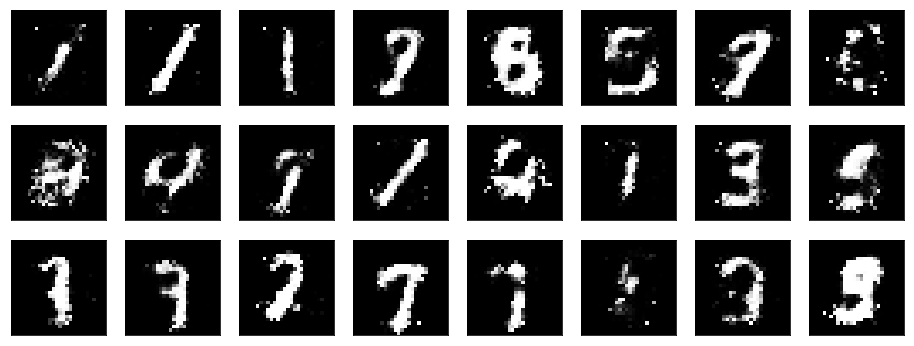

Epoch 61/400
 - 17s - g_loss: 1.9880 - d_loss: 0.6373 - d_acc: 0.6761
Epoch 62/400
 - 20s - g_loss: 1.8904 - d_loss: 0.6554 - d_acc: 0.6628
Epoch 63/400
 - 18s - g_loss: 1.6601 - d_loss: 0.6349 - d_acc: 0.6637
Epoch 64/400
 - 19s - g_loss: 1.8391 - d_loss: 0.6463 - d_acc: 0.6630
Epoch 65/400
 - 18s - g_loss: 2.3814 - d_loss: 0.6048 - d_acc: 0.6945
Epoch 66/400
 - 20s - g_loss: 1.8300 - d_loss: 0.6583 - d_acc: 0.6614
Epoch 67/400
 - 19s - g_loss: 1.7895 - d_loss: 0.6610 - d_acc: 0.6572
Epoch 68/400
 - 28s - g_loss: 2.1949 - d_loss: 0.6295 - d_acc: 0.6818
Epoch 69/400
 - 23s - g_loss: 2.0266 - d_loss: 0.6540 - d_acc: 0.6707
Epoch 70/400
 - 20s - g_loss: 2.1443 - d_loss: 0.6467 - d_acc: 0.6730
Epoch 71/400
 - 20s - g_loss: 1.9468 - d_loss: 0.6704 - d_acc: 0.6487
Epoch 72/400
 - 24s - g_loss: 1.6744 - d_loss: 0.6638 - d_acc: 0.6522
Epoch 73/400
 - 21s - g_loss: 2.0391 - d_loss: 0.6649 - d_acc: 0.6640
Epoch 74/400
 - 25s - g_loss: 1.8602 - d_loss: 0.6579 - d_acc: 0.6573
Epoch 75/400
 - 21s 

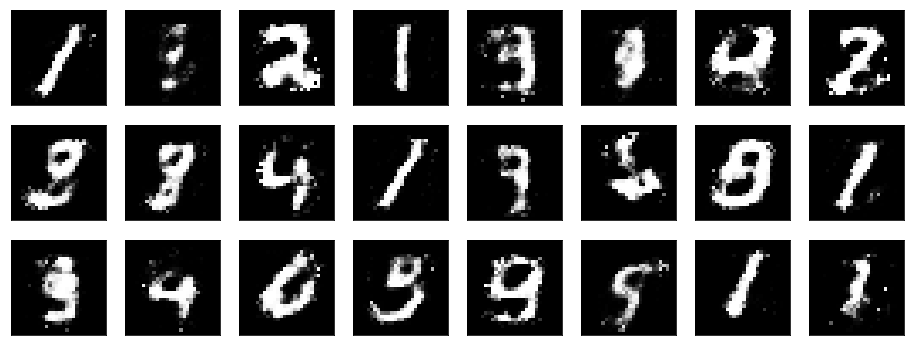

Epoch 81/400
 - 18s - g_loss: 1.8009 - d_loss: 0.6747 - d_acc: 0.6462
Epoch 82/400
 - 19s - g_loss: 1.6990 - d_loss: 0.6812 - d_acc: 0.6342
Epoch 83/400
 - 23s - g_loss: 1.5263 - d_loss: 0.6405 - d_acc: 0.6482
Epoch 84/400
 - 19s - g_loss: 1.7648 - d_loss: 0.6622 - d_acc: 0.6532
Epoch 85/400
 - 22s - g_loss: 1.7238 - d_loss: 0.6812 - d_acc: 0.6438
Epoch 86/400
 - 22s - g_loss: 1.7237 - d_loss: 0.6871 - d_acc: 0.6398
Epoch 87/400
 - 18s - g_loss: 1.7663 - d_loss: 0.6840 - d_acc: 0.6413
Epoch 88/400
 - 19s - g_loss: 1.8988 - d_loss: 0.6602 - d_acc: 0.6578
Epoch 89/400
 - 26s - g_loss: 1.7145 - d_loss: 0.6801 - d_acc: 0.6412
Epoch 90/400
 - 22s - g_loss: 1.7496 - d_loss: 0.6846 - d_acc: 0.6420
Epoch 91/400
 - 20s - g_loss: 1.6761 - d_loss: 0.6841 - d_acc: 0.6397
Epoch 92/400
 - 22s - g_loss: 1.8894 - d_loss: 0.6692 - d_acc: 0.6531
Epoch 93/400
 - 18s - g_loss: 1.7811 - d_loss: 0.6882 - d_acc: 0.6370
Epoch 94/400
 - 21s - g_loss: 1.6555 - d_loss: 0.6783 - d_acc: 0.6405
Epoch 95/400
 - 16s 

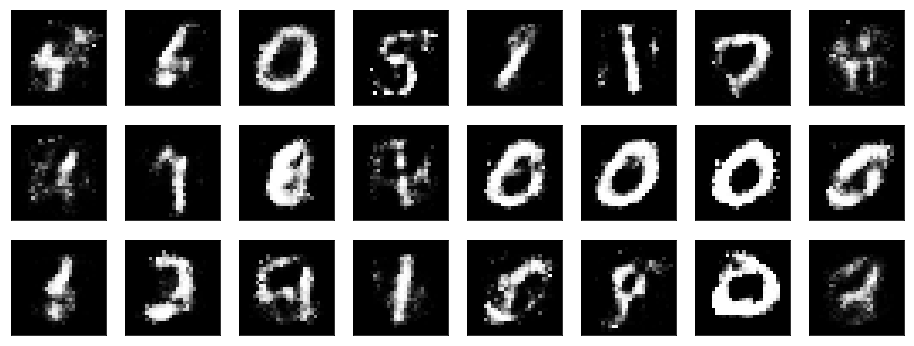

Epoch 101/400
 - 19s - g_loss: 1.7180 - d_loss: 0.6845 - d_acc: 0.6400
Epoch 102/400
 - 19s - g_loss: 1.9771 - d_loss: 0.6765 - d_acc: 0.6504
Epoch 103/400
 - 20s - g_loss: 1.9003 - d_loss: 0.6642 - d_acc: 0.6516
Epoch 104/400
 - 20s - g_loss: 1.7046 - d_loss: 0.6871 - d_acc: 0.6349
Epoch 105/400
 - 19s - g_loss: 1.7845 - d_loss: 0.6933 - d_acc: 0.6355
Epoch 106/400
 - 17s - g_loss: 1.7615 - d_loss: 0.6966 - d_acc: 0.6307
Epoch 107/400
 - 20s - g_loss: 1.3052 - d_loss: 0.6645 - d_acc: 0.6310
Epoch 108/400
 - 17s - g_loss: 1.6365 - d_loss: 0.6961 - d_acc: 0.6312
Epoch 109/400
 - 20s - g_loss: 1.5748 - d_loss: 0.7037 - d_acc: 0.6261
Epoch 110/400
 - 23s - g_loss: 1.5736 - d_loss: 0.7061 - d_acc: 0.6248
Epoch 111/400
 - 18s - g_loss: 1.7217 - d_loss: 0.6767 - d_acc: 0.6389
Epoch 112/400
 - 20s - g_loss: 1.6901 - d_loss: 0.6884 - d_acc: 0.6353
Epoch 113/400
 - 25s - g_loss: 1.6891 - d_loss: 0.6919 - d_acc: 0.6336
Epoch 114/400
 - 17s - g_loss: 1.7324 - d_loss: 0.6931 - d_acc: 0.6361
Epoch 

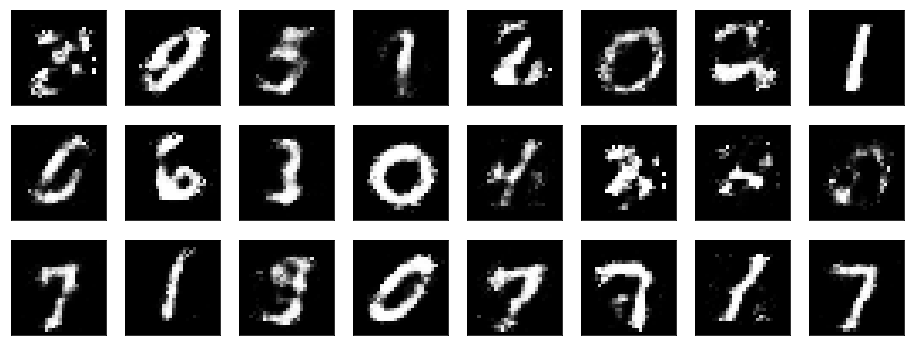

Epoch 121/400
 - 20s - g_loss: 1.5784 - d_loss: 0.7042 - d_acc: 0.6223
Epoch 122/400
 - 24s - g_loss: 1.6034 - d_loss: 0.7049 - d_acc: 0.6230
Epoch 123/400
 - 18s - g_loss: 1.5467 - d_loss: 0.7043 - d_acc: 0.6243
Epoch 124/400
 - 23s - g_loss: 1.8015 - d_loss: 0.7035 - d_acc: 0.6301
Epoch 125/400
 - 21s - g_loss: 1.7520 - d_loss: 0.6919 - d_acc: 0.6355
Epoch 126/400
 - 23s - g_loss: 1.5108 - d_loss: 0.6956 - d_acc: 0.6261
Epoch 127/400
 - 29s - g_loss: 1.3662 - d_loss: 0.7009 - d_acc: 0.6148
Epoch 128/400
 - 17s - g_loss: 1.8059 - d_loss: 0.7059 - d_acc: 0.6320
Epoch 129/400
 - 22s - g_loss: 1.3985 - d_loss: 0.6982 - d_acc: 0.6196
Epoch 130/400
 - 24s - g_loss: 1.5878 - d_loss: 0.7283 - d_acc: 0.6144
Epoch 131/400
 - 23s - g_loss: 1.4493 - d_loss: 0.7155 - d_acc: 0.6128
Epoch 132/400
 - 20s - g_loss: 1.3983 - d_loss: 0.7293 - d_acc: 0.6006
Epoch 133/400
 - 20s - g_loss: 1.6437 - d_loss: 0.7241 - d_acc: 0.6170
Epoch 134/400
 - 19s - g_loss: 1.4178 - d_loss: 0.6594 - d_acc: 0.6336
Epoch 

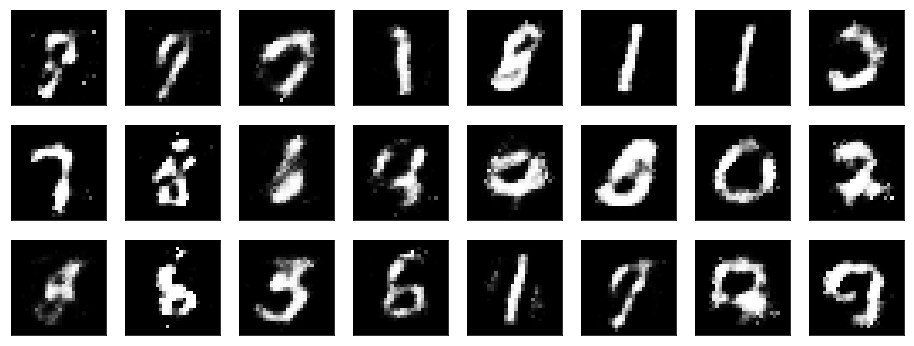

Epoch 141/400
 - 21s - g_loss: 1.5446 - d_loss: 0.7262 - d_acc: 0.6110
Epoch 142/400
 - 21s - g_loss: 1.9372 - d_loss: 0.6995 - d_acc: 0.6371
Epoch 143/400
 - 20s - g_loss: 1.3941 - d_loss: 0.7040 - d_acc: 0.6170
Epoch 144/400
 - 20s - g_loss: 1.3198 - d_loss: 0.7140 - d_acc: 0.6079
Epoch 145/400
 - 19s - g_loss: 1.4411 - d_loss: 0.7313 - d_acc: 0.6039
Epoch 146/400
 - 24s - g_loss: 1.8587 - d_loss: 0.7164 - d_acc: 0.6303
Epoch 147/400
 - 28s - g_loss: 1.1877 - d_loss: 0.7033 - d_acc: 0.5997
Epoch 148/400
 - 19s - g_loss: 1.6963 - d_loss: 0.7336 - d_acc: 0.6172
Epoch 149/400
 - 20s - g_loss: 1.3794 - d_loss: 0.7137 - d_acc: 0.6110
Epoch 150/400
 - 19s - g_loss: 1.7608 - d_loss: 0.7157 - d_acc: 0.6230
Epoch 151/400
 - 17s - g_loss: 1.4270 - d_loss: 0.7050 - d_acc: 0.6150
Epoch 152/400
 - 22s - g_loss: 1.3720 - d_loss: 0.7249 - d_acc: 0.6063
Epoch 153/400
 - 21s - g_loss: 1.5700 - d_loss: 0.7212 - d_acc: 0.6179
Epoch 154/400
 - 22s - g_loss: 1.4222 - d_loss: 0.7067 - d_acc: 0.6136
Epoch 

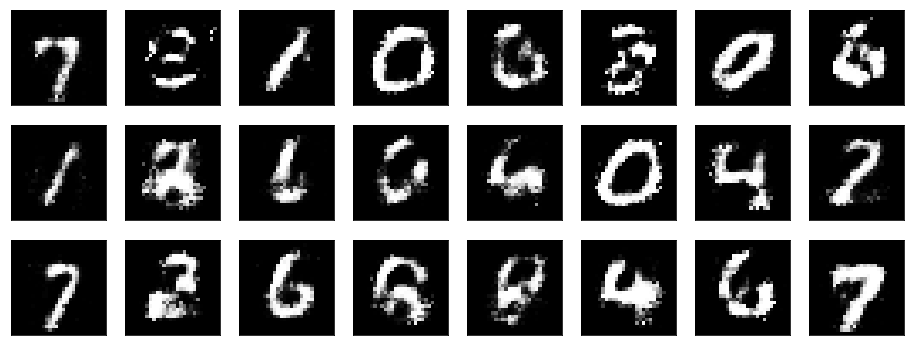

Epoch 161/400
 - 19s - g_loss: 1.4954 - d_loss: 0.7234 - d_acc: 0.6141
Epoch 162/400
 - 20s - g_loss: 1.4317 - d_loss: 0.7110 - d_acc: 0.6107
Epoch 163/400
 - 18s - g_loss: 1.6896 - d_loss: 0.7113 - d_acc: 0.6170
Epoch 164/400
 - 18s - g_loss: 1.3010 - d_loss: 0.7094 - d_acc: 0.6066
Epoch 165/400
 - 20s - g_loss: 1.3530 - d_loss: 0.7304 - d_acc: 0.5979
Epoch 166/400
 - 19s - g_loss: 1.3263 - d_loss: 0.7272 - d_acc: 0.5988
Epoch 167/400
 - 20s - g_loss: 1.3696 - d_loss: 0.7481 - d_acc: 0.5901
Epoch 168/400
 - 21s - g_loss: 1.4280 - d_loss: 0.7191 - d_acc: 0.6082
Epoch 169/400
 - 17s - g_loss: 1.4603 - d_loss: 0.7267 - d_acc: 0.6043
Epoch 170/400
 - 20s - g_loss: 1.4924 - d_loss: 0.7020 - d_acc: 0.6200
Epoch 171/400
 - 20s - g_loss: 1.4119 - d_loss: 0.7335 - d_acc: 0.5983
Epoch 172/400
 - 17s - g_loss: 1.2511 - d_loss: 0.7254 - d_acc: 0.5924
Epoch 173/400
 - 22s - g_loss: 1.7460 - d_loss: 0.7537 - d_acc: 0.6030
Epoch 174/400
 - 23s - g_loss: 1.1685 - d_loss: 0.6666 - d_acc: 0.6164
Epoch 

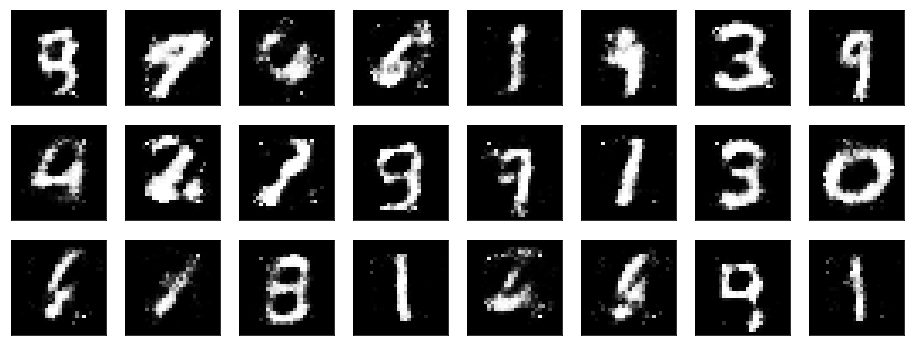

Epoch 181/400
 - 18s - g_loss: 1.8518 - d_loss: 0.7237 - d_acc: 0.6246
Epoch 182/400
 - 23s - g_loss: 1.5373 - d_loss: 0.7335 - d_acc: 0.5961
Epoch 183/400
 - 21s - g_loss: 1.1402 - d_loss: 0.6620 - d_acc: 0.6206
Epoch 184/400
 - 20s - g_loss: 1.3557 - d_loss: 0.7167 - d_acc: 0.6022
Epoch 185/400
 - 20s - g_loss: 1.4333 - d_loss: 0.7443 - d_acc: 0.5982
Epoch 186/400
 - 21s - g_loss: 1.4041 - d_loss: 0.7498 - d_acc: 0.5915
Epoch 187/400
 - 18s - g_loss: 1.2993 - d_loss: 0.7191 - d_acc: 0.5966
Epoch 188/400
 - 25s - g_loss: 1.4110 - d_loss: 0.7442 - d_acc: 0.5928
Epoch 189/400
 - 22s - g_loss: 1.5450 - d_loss: 0.7129 - d_acc: 0.6195
Epoch 190/400
 - 28s - g_loss: 1.2305 - d_loss: 0.7225 - d_acc: 0.5934
Epoch 191/400
 - 24s - g_loss: 1.3761 - d_loss: 0.7620 - d_acc: 0.5849
Epoch 192/400
 - 18s - g_loss: 1.3225 - d_loss: 0.7557 - d_acc: 0.5811
Epoch 193/400
 - 17s - g_loss: 1.3431 - d_loss: 0.7553 - d_acc: 0.5873
Epoch 194/400
 - 19s - g_loss: 1.2746 - d_loss: 0.7515 - d_acc: 0.5849
Epoch 

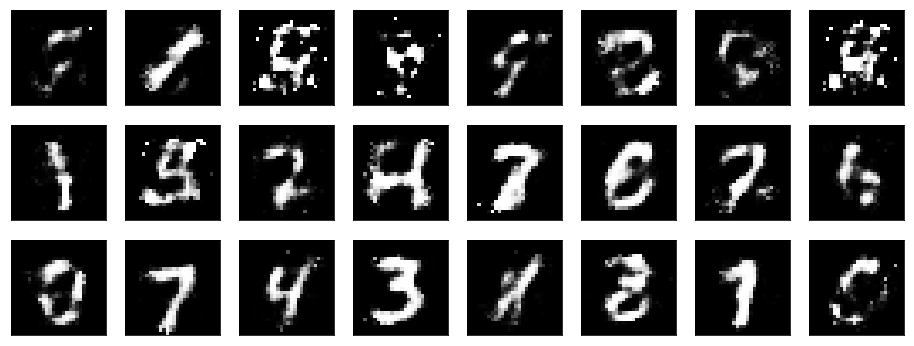

Epoch 201/400
 - 18s - g_loss: 1.3152 - d_loss: 0.7342 - d_acc: 0.5908
Epoch 202/400
 - 24s - g_loss: 1.3259 - d_loss: 0.7300 - d_acc: 0.5953
Epoch 203/400
 - 20s - g_loss: 1.2390 - d_loss: 0.7420 - d_acc: 0.5832
Epoch 204/400
 - 19s - g_loss: 1.2869 - d_loss: 0.7424 - d_acc: 0.5868
Epoch 205/400
 - 20s - g_loss: 1.5049 - d_loss: 0.7418 - d_acc: 0.6031
Epoch 206/400
 - 19s - g_loss: 1.2566 - d_loss: 0.7419 - d_acc: 0.5830
Epoch 207/400
 - 23s - g_loss: 1.3129 - d_loss: 0.7484 - d_acc: 0.5841
Epoch 208/400
 - 22s - g_loss: 1.2523 - d_loss: 0.7398 - d_acc: 0.5860
Epoch 209/400
 - 20s - g_loss: 1.3294 - d_loss: 0.7537 - d_acc: 0.5838
Epoch 210/400
 - 19s - g_loss: 1.3926 - d_loss: 0.7214 - d_acc: 0.6033
Epoch 211/400
 - 25s - g_loss: 1.3205 - d_loss: 0.7372 - d_acc: 0.5888
Epoch 212/400
 - 17s - g_loss: 1.2573 - d_loss: 0.7375 - d_acc: 0.5832
Epoch 213/400
 - 20s - g_loss: 1.2668 - d_loss: 0.7307 - d_acc: 0.5919
Epoch 214/400
 - 22s - g_loss: 1.2859 - d_loss: 0.7450 - d_acc: 0.5887
Epoch 

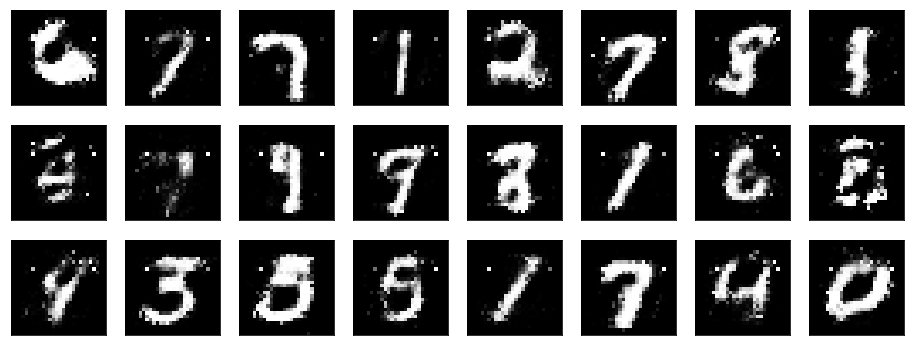

Epoch 221/400
 - 18s - g_loss: 1.2812 - d_loss: 0.7514 - d_acc: 0.5851
Epoch 222/400
 - 19s - g_loss: 1.2878 - d_loss: 0.7569 - d_acc: 0.5806
Epoch 223/400
 - 19s - g_loss: 1.3705 - d_loss: 0.7620 - d_acc: 0.5870
Epoch 224/400
 - 19s - g_loss: 1.2886 - d_loss: 0.7311 - d_acc: 0.5875
Epoch 225/400
 - 23s - g_loss: 1.3642 - d_loss: 0.7235 - d_acc: 0.6005
Epoch 226/400
 - 23s - g_loss: 1.2300 - d_loss: 0.7343 - d_acc: 0.5862
Epoch 227/400
 - 19s - g_loss: 1.2327 - d_loss: 0.7496 - d_acc: 0.5785
Epoch 228/400
 - 20s - g_loss: 1.3279 - d_loss: 0.7648 - d_acc: 0.5805
Epoch 229/400
 - 24s - g_loss: 1.2607 - d_loss: 0.7522 - d_acc: 0.5762
Epoch 230/400
 - 18s - g_loss: 1.3895 - d_loss: 0.7552 - d_acc: 0.5829
Epoch 231/400
 - 24s - g_loss: 1.1067 - d_loss: 0.7179 - d_acc: 0.5858
Epoch 232/400
 - 25s - g_loss: 1.2497 - d_loss: 0.7462 - d_acc: 0.5817
Epoch 233/400
 - 18s - g_loss: 1.3287 - d_loss: 0.7509 - d_acc: 0.5869
Epoch 234/400
 - 21s - g_loss: 1.2196 - d_loss: 0.7673 - d_acc: 0.5650
Epoch 

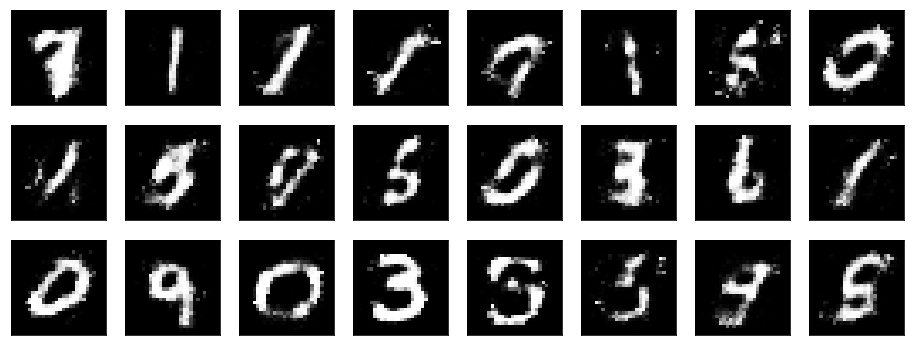

Epoch 241/400
 - 19s - g_loss: 1.2274 - d_loss: 0.7421 - d_acc: 0.5829
Epoch 242/400
 - 20s - g_loss: 1.3873 - d_loss: 0.7230 - d_acc: 0.6021
Epoch 243/400
 - 20s - g_loss: 1.3174 - d_loss: 0.7367 - d_acc: 0.5896
Epoch 244/400
 - 24s - g_loss: 1.2285 - d_loss: 0.7410 - d_acc: 0.5806
Epoch 245/400
 - 19s - g_loss: 1.2172 - d_loss: 0.7560 - d_acc: 0.5715
Epoch 246/400
 - 19s - g_loss: 1.2928 - d_loss: 0.7400 - d_acc: 0.5857
Epoch 247/400
 - 23s - g_loss: 1.2485 - d_loss: 0.7655 - d_acc: 0.5714
Epoch 248/400
 - 20s - g_loss: 1.5094 - d_loss: 0.7215 - d_acc: 0.6065
Epoch 249/400
 - 21s - g_loss: 1.2513 - d_loss: 0.7419 - d_acc: 0.5841
Epoch 250/400
 - 19s - g_loss: 1.2084 - d_loss: 0.7366 - d_acc: 0.5853
Epoch 251/400
 - 20s - g_loss: 1.3236 - d_loss: 0.7369 - d_acc: 0.5887
Epoch 252/400
 - 17s - g_loss: 1.2876 - d_loss: 0.7494 - d_acc: 0.5825
Epoch 253/400
 - 20s - g_loss: 1.2788 - d_loss: 0.7330 - d_acc: 0.5906
Epoch 254/400
 - 20s - g_loss: 1.2620 - d_loss: 0.7319 - d_acc: 0.5903
Epoch 

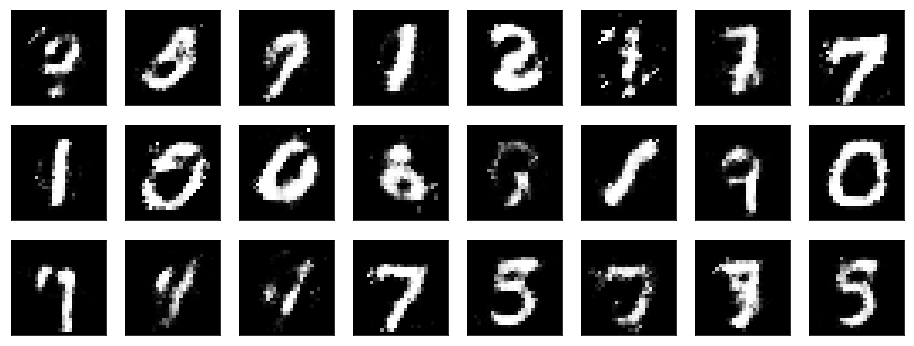

Epoch 261/400
 - 20s - g_loss: 1.2654 - d_loss: 0.7418 - d_acc: 0.5850
Epoch 262/400
 - 24s - g_loss: 1.1767 - d_loss: 0.7490 - d_acc: 0.5760
Epoch 263/400
 - 17s - g_loss: 1.2475 - d_loss: 0.7604 - d_acc: 0.5759
Epoch 264/400
 - 22s - g_loss: 1.2729 - d_loss: 0.7394 - d_acc: 0.5854
Epoch 265/400
 - 21s - g_loss: 1.2282 - d_loss: 0.7446 - d_acc: 0.5802
Epoch 266/400
 - 18s - g_loss: 1.2364 - d_loss: 0.7438 - d_acc: 0.5801
Epoch 267/400
 - 20s - g_loss: 1.2414 - d_loss: 0.7413 - d_acc: 0.5811
Epoch 268/400
 - 20s - g_loss: 1.1734 - d_loss: 0.7396 - d_acc: 0.5763
Epoch 269/400
 - 16s - g_loss: 1.3361 - d_loss: 0.7458 - d_acc: 0.5893
Epoch 270/400
 - 18s - g_loss: 1.3009 - d_loss: 0.7659 - d_acc: 0.5780
Epoch 271/400
 - 20s - g_loss: 1.3104 - d_loss: 0.7663 - d_acc: 0.5771
Epoch 272/400
 - 19s - g_loss: 1.2403 - d_loss: 0.7431 - d_acc: 0.5830
Epoch 273/400
 - 24s - g_loss: 1.3571 - d_loss: 0.7308 - d_acc: 0.5930
Epoch 274/400
 - 25s - g_loss: 1.1683 - d_loss: 0.7336 - d_acc: 0.5852
Epoch 

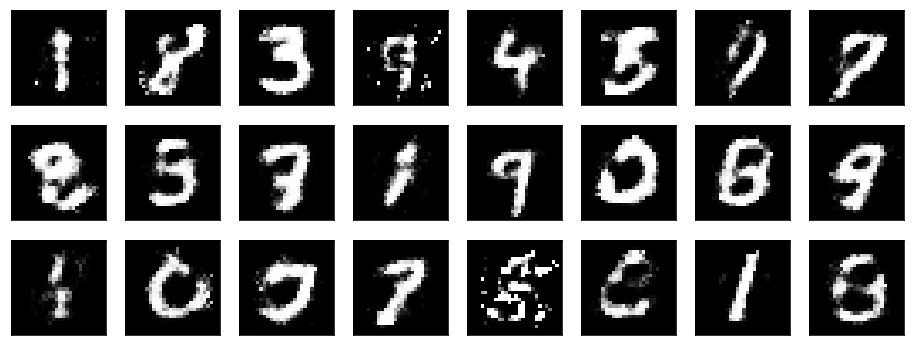

Epoch 281/400
 - 17s - g_loss: 1.2107 - d_loss: 0.7418 - d_acc: 0.5811
Epoch 282/400
 - 21s - g_loss: 1.2862 - d_loss: 0.7513 - d_acc: 0.5812
Epoch 283/400
 - 20s - g_loss: 1.1289 - d_loss: 0.7432 - d_acc: 0.5721
Epoch 284/400
 - 20s - g_loss: 1.2464 - d_loss: 0.7642 - d_acc: 0.5715
Epoch 285/400
 - 26s - g_loss: 1.2749 - d_loss: 0.7707 - d_acc: 0.5704
Epoch 286/400
 - 18s - g_loss: 1.3023 - d_loss: 0.7686 - d_acc: 0.5752
Epoch 287/400
 - 22s - g_loss: 1.0842 - d_loss: 0.7339 - d_acc: 0.5732
Epoch 288/400
 - 25s - g_loss: 1.3423 - d_loss: 0.7643 - d_acc: 0.5801
Epoch 289/400
 - 18s - g_loss: 1.1485 - d_loss: 0.7461 - d_acc: 0.5706
Epoch 290/400
 - 20s - g_loss: 1.1656 - d_loss: 0.7618 - d_acc: 0.5640
Epoch 291/400
 - 24s - g_loss: 1.3097 - d_loss: 0.7239 - d_acc: 0.5936
Epoch 292/400
 - 18s - g_loss: 1.2175 - d_loss: 0.7487 - d_acc: 0.5772
Epoch 293/400
 - 18s - g_loss: 1.2208 - d_loss: 0.7531 - d_acc: 0.5738
Epoch 294/400
 - 23s - g_loss: 1.2499 - d_loss: 0.7482 - d_acc: 0.5793
Epoch 

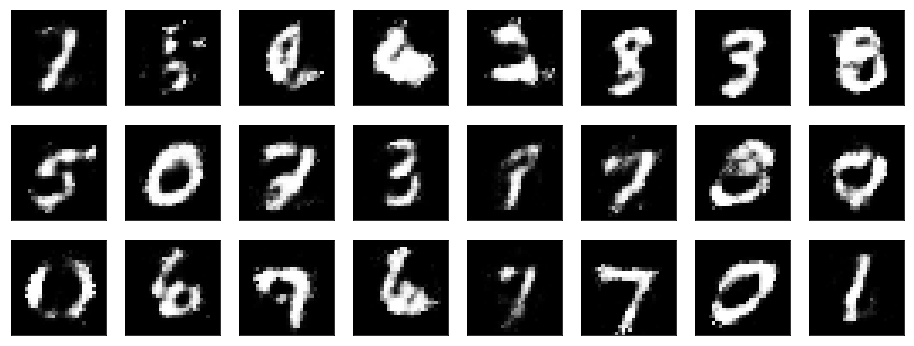

Epoch 301/400
 - 17s - g_loss: 1.2014 - d_loss: 0.7503 - d_acc: 0.5733
Epoch 302/400
 - 20s - g_loss: 1.4165 - d_loss: 0.7241 - d_acc: 0.6017
Epoch 303/400
 - 23s - g_loss: 1.1906 - d_loss: 0.7469 - d_acc: 0.5764
Epoch 304/400
 - 18s - g_loss: 1.2127 - d_loss: 0.7365 - d_acc: 0.5818
Epoch 305/400
 - 22s - g_loss: 1.2331 - d_loss: 0.7485 - d_acc: 0.5787
Epoch 306/400
 - 22s - g_loss: 1.2189 - d_loss: 0.7498 - d_acc: 0.5804
Epoch 307/400
 - 19s - g_loss: 1.3218 - d_loss: 0.7705 - d_acc: 0.5728
Epoch 308/400
 - 21s - g_loss: 1.1356 - d_loss: 0.7537 - d_acc: 0.5658
Epoch 309/400
 - 23s - g_loss: 1.1717 - d_loss: 0.7542 - d_acc: 0.5676
Epoch 310/400
 - 19s - g_loss: 1.1787 - d_loss: 0.7624 - d_acc: 0.5661
Epoch 311/400
 - 21s - g_loss: 1.1621 - d_loss: 0.7633 - d_acc: 0.5628
Epoch 312/400
 - 21s - g_loss: 1.1452 - d_loss: 0.7637 - d_acc: 0.5607
Epoch 313/400
 - 21s - g_loss: 1.1381 - d_loss: 0.7656 - d_acc: 0.5591
Epoch 314/400
 - 25s - g_loss: 1.1911 - d_loss: 0.7597 - d_acc: 0.5649
Epoch 

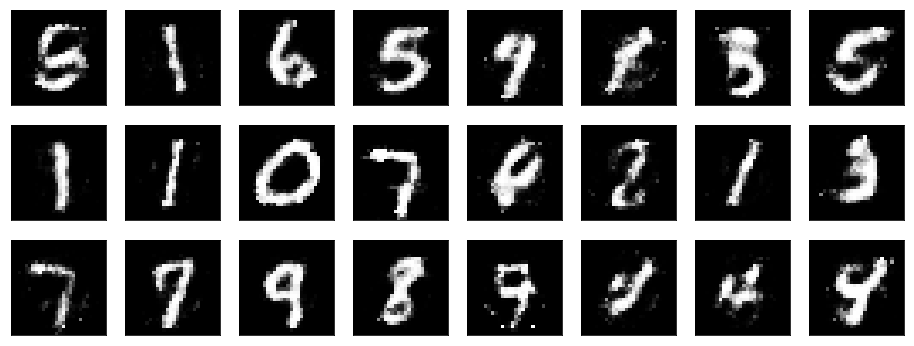

Epoch 321/400
 - 18s - g_loss: 1.2555 - d_loss: 0.7686 - d_acc: 0.5689
Epoch 322/400
 - 21s - g_loss: 1.2699 - d_loss: 0.7741 - d_acc: 0.5654
Epoch 323/400
 - 21s - g_loss: 1.2884 - d_loss: 0.7390 - d_acc: 0.5898
Epoch 324/400
 - 20s - g_loss: 1.2069 - d_loss: 0.7388 - d_acc: 0.5786
Epoch 325/400
 - 20s - g_loss: 1.1600 - d_loss: 0.7357 - d_acc: 0.5796
Epoch 326/400
 - 21s - g_loss: 1.1736 - d_loss: 0.7489 - d_acc: 0.5690
Epoch 327/400
 - 16s - g_loss: 1.2520 - d_loss: 0.7377 - d_acc: 0.5804
Epoch 328/400
 - 22s - g_loss: 1.1145 - d_loss: 0.7510 - d_acc: 0.5635
Epoch 329/400
 - 24s - g_loss: 1.1629 - d_loss: 0.7497 - d_acc: 0.5711
Epoch 330/400
 - 19s - g_loss: 1.2371 - d_loss: 0.7633 - d_acc: 0.5704
Epoch 331/400
 - 23s - g_loss: 1.1681 - d_loss: 0.7383 - d_acc: 0.5789
Epoch 332/400
 - 22s - g_loss: 1.2884 - d_loss: 0.7613 - d_acc: 0.5746
Epoch 333/400
 - 19s - g_loss: 1.1522 - d_loss: 0.7451 - d_acc: 0.5727
Epoch 334/400
 - 22s - g_loss: 1.1961 - d_loss: 0.7562 - d_acc: 0.5712
Epoch 

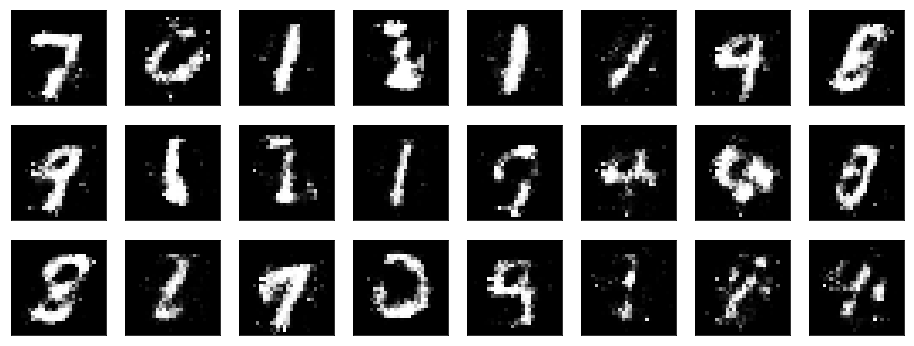

Epoch 341/400
 - 18s - g_loss: 1.2398 - d_loss: 0.7603 - d_acc: 0.5727
Epoch 342/400
 - 17s - g_loss: 1.1565 - d_loss: 0.7407 - d_acc: 0.5754
Epoch 343/400
 - 24s - g_loss: 1.1485 - d_loss: 0.7629 - d_acc: 0.5637
Epoch 344/400
 - 25s - g_loss: 1.1647 - d_loss: 0.7623 - d_acc: 0.5638
Epoch 345/400
 - 21s - g_loss: 1.2160 - d_loss: 0.7574 - d_acc: 0.5731
Epoch 346/400
 - 25s - g_loss: 1.1954 - d_loss: 0.7749 - d_acc: 0.5599
Epoch 347/400
 - 18s - g_loss: 1.1716 - d_loss: 0.7701 - d_acc: 0.5610
Epoch 348/400
 - 23s - g_loss: 1.3409 - d_loss: 0.7873 - d_acc: 0.5620
Epoch 349/400
 - 25s - g_loss: 1.0302 - d_loss: 0.7201 - d_acc: 0.5722
Epoch 350/400
 - 20s - g_loss: 1.3868 - d_loss: 0.7631 - d_acc: 0.5816
Epoch 351/400
 - 22s - g_loss: 1.0290 - d_loss: 0.7301 - d_acc: 0.5700
Epoch 352/400
 - 25s - g_loss: 1.2524 - d_loss: 0.7540 - d_acc: 0.5788
Epoch 353/400
 - 18s - g_loss: 1.2345 - d_loss: 0.7687 - d_acc: 0.5683
Epoch 354/400
 - 19s - g_loss: 1.1661 - d_loss: 0.7580 - d_acc: 0.5685
Epoch 

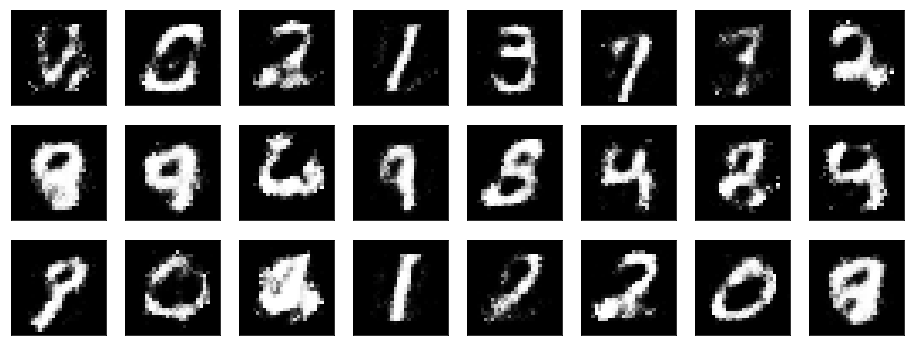

Epoch 361/400
 - 15s - g_loss: 1.2562 - d_loss: 0.7785 - d_acc: 0.5647
Epoch 362/400
 - 18s - g_loss: 1.1392 - d_loss: 0.7584 - d_acc: 0.5625
Epoch 363/400
 - 20s - g_loss: 1.1098 - d_loss: 0.7502 - d_acc: 0.5641
Epoch 364/400
 - 21s - g_loss: 1.2139 - d_loss: 0.7408 - d_acc: 0.5785
Epoch 365/400
 - 31s - g_loss: 1.3678 - d_loss: 0.7264 - d_acc: 0.5980
Epoch 366/400
 - 23s - g_loss: 1.2596 - d_loss: 0.7407 - d_acc: 0.5832
Epoch 367/400
 - 17s - g_loss: 1.2369 - d_loss: 0.7496 - d_acc: 0.5810
Epoch 368/400
 - 18s - g_loss: 1.2088 - d_loss: 0.7525 - d_acc: 0.5758
Epoch 369/400
 - 24s - g_loss: 1.1368 - d_loss: 0.7504 - d_acc: 0.5679
Epoch 370/400
 - 19s - g_loss: 1.1262 - d_loss: 0.7494 - d_acc: 0.5686
Epoch 371/400
 - 25s - g_loss: 1.1616 - d_loss: 0.7535 - d_acc: 0.5666
Epoch 372/400
 - 22s - g_loss: 1.2114 - d_loss: 0.7407 - d_acc: 0.5772
Epoch 373/400
 - 18s - g_loss: 1.2190 - d_loss: 0.7680 - d_acc: 0.5660
Epoch 374/400
 - 22s - g_loss: 1.1708 - d_loss: 0.7654 - d_acc: 0.5656
Epoch 

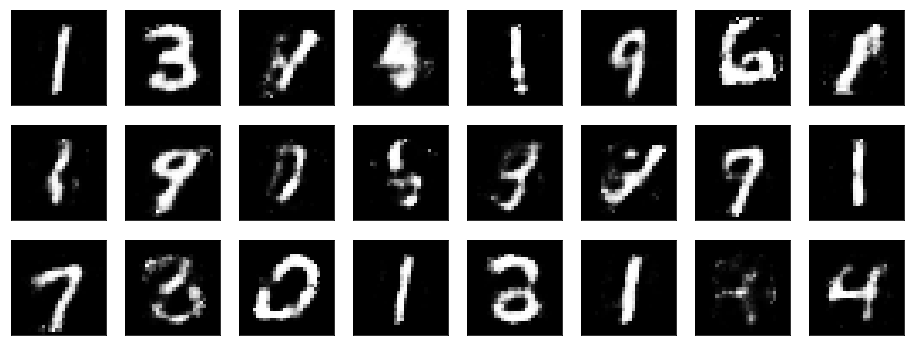

Epoch 381/400
 - 17s - g_loss: 1.1381 - d_loss: 0.7472 - d_acc: 0.5709
Epoch 382/400
 - 19s - g_loss: 1.1608 - d_loss: 0.7641 - d_acc: 0.5628
Epoch 383/400
 - 23s - g_loss: 1.1453 - d_loss: 0.7664 - d_acc: 0.5597
Epoch 384/400
 - 18s - g_loss: 1.3556 - d_loss: 0.7769 - d_acc: 0.5754
Epoch 385/400
 - 18s - g_loss: 1.1391 - d_loss: 0.7391 - d_acc: 0.5727
Epoch 386/400
 - 25s - g_loss: 1.1743 - d_loss: 0.7393 - d_acc: 0.5744
Epoch 387/400
 - 21s - g_loss: 1.2611 - d_loss: 0.7356 - d_acc: 0.5861
Epoch 388/400
 - 25s - g_loss: 1.1709 - d_loss: 0.7425 - d_acc: 0.5763
Epoch 389/400
 - 22s - g_loss: 1.0576 - d_loss: 0.7225 - d_acc: 0.5766
Epoch 390/400
 - 20s - g_loss: 1.1333 - d_loss: 0.7591 - d_acc: 0.5609
Epoch 391/400
 - 25s - g_loss: 1.1589 - d_loss: 0.7461 - d_acc: 0.5729
Epoch 392/400
 - 18s - g_loss: 1.1971 - d_loss: 0.7599 - d_acc: 0.5681
Epoch 393/400
 - 21s - g_loss: 1.1791 - d_loss: 0.7501 - d_acc: 0.5722
Epoch 394/400
 - 22s - g_loss: 1.1968 - d_loss: 0.7445 - d_acc: 0.5779
Epoch 

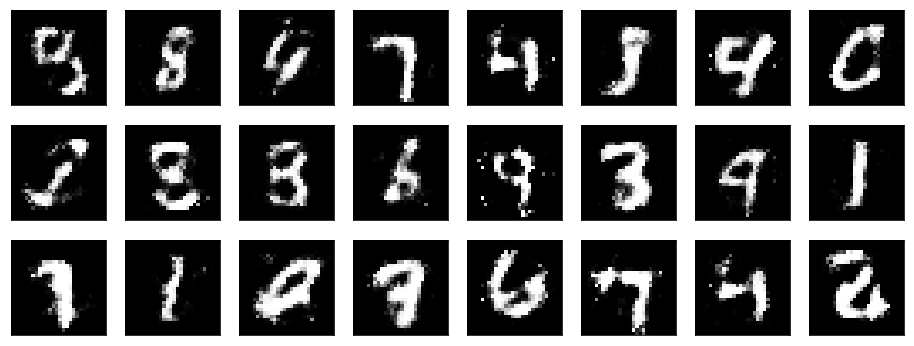

In [11]:
history = train(train_x, epochs=400, batch_size=50)

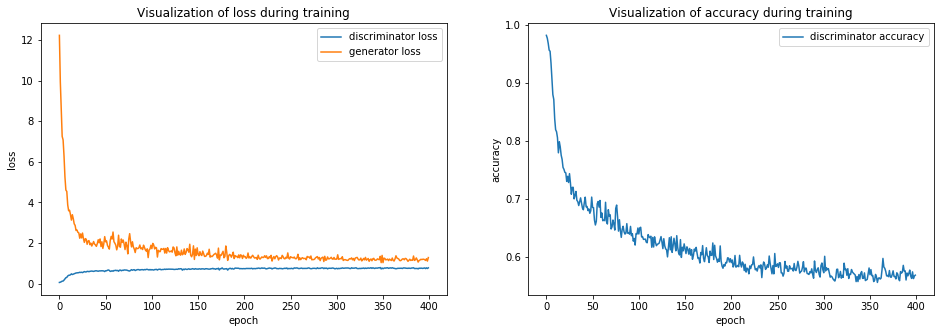

In [12]:
plot_history(history)